## Introduction

This notebook provides a guide on how to develop custom optimizers utilizing the [TensorFlow Core low-level APIs](https://www.tensorflow.org/guide/core), a foundational aspect of TensorFlow designed for in-depth control and flexibility in machine learning development. For a broader understanding of TensorFlow Core and its applications, consider exploring the [Core APIs overview](https://www.tensorflow.org/guide/core).

While the [Keras optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) module is a comprehensive and preferred optimization resource for various training endeavors, offering a wide selection of optimizers ready for immediate use as well as the option to create tailored optimizers via subclassing, there are scenarios where deeper customization is required. The Keras optimizers are engineered to integrate smoothly with custom layers and models fashioned using the Core APIs. However, the Core APIs provide unmatched control for those looking to delve into the intricacies of the optimization process. This is particularly relevant for implementing advanced optimization techniques like Sharpness-Aware Minimization (SAM), which demands a closer synergy between the model and the optimizer, extending beyond the traditional boundaries of ML optimizers. This tutorial aims to equip users with the knowledge to construct their own optimizers from scratch with the Core APIs, offering full command over the optimization process's nuances.

## Optimizers overview

An optimizer is a method designed to reduce a loss function concerning the trainable parameters of a model. Gradient descent stands as the most basic form of optimization, methodically adjusting the model's parameters by moving towards the direction where the loss function decreases most sharply. The magnitude of the adjustment is dependent on the gradient's size, which poses challenges if the gradient is excessively large or small. Numerous other optimization strategies, including Adam, Adagrad, and RMSprop, utilize different characteristics of gradients to enhance memory usage efficiency and accelerate convergence. These optimizers employ advanced techniques to navigate the challenges posed by gradient magnitude, offering more sophisticated solutions for optimizing model performance.

## Setup

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [ ]:
import tensorflow as tf
print(tf.__version__)
# set random seed for reproducible results
tf.random.set_seed(22)

2.15.0


## Gradient descent

A fundamental optimizer class needs to include a method for initialization and a function for updating a set of variables based on their corresponding gradients. Begin by creating a simple gradient descent optimizer, which adjusts each variable by deducting the product of its gradient and a scaling factor known as the learning rate.

In [ ]:
class GradientDescent(tf.Module):

    def __init__(self, learning_rate=1e-3):
        # Initialize parameters
        self.learning_rate = learning_rate
        self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

    def apply_gradients(self, grads, vars):
        # Update variables
        for grad, var in zip(grads, vars):
            var.assign_sub(self.learning_rate*grad)

To conduct an evaluation of this optimizer, we will craft a sample loss function that needs to be minimized in relation to a single variable, denoted as $x$. This involves first determining the explicit form of the loss function, then calculating its gradient function to identify the value of $x$ that minimizes the function.

The loss function in question is represented as $L = 2x^4 + 3x^3 + 2$. This equation describes how the loss changes as a function of $x$. To find the value of $x$ that minimizes this loss, we need to look at the rate of change of $L$ with respect to $x$, which is found by computing the derivative of $L$ with respect to $x$.

The gradient function, or the derivative of the loss function with respect to $x$, is given by $\frac{dL}{dx} = 8x^3 + 9x^2$. This mathematical expression represents the slope of the loss function at any point $x$, and it's crucial for finding the points where the loss function is minimized.

Analyzing the gradient function, we seek the values of $x$ where this gradient is zero because such points indicate either a minimum, maximum, or saddle point of the loss function. Upon solving $\frac{dL}{dx} = 0$, we identify two critical points: $x = 0$ and $x = - \frac{9}{8}$.

The point $x = 0$ is identified as a saddle point, a type of critical point where the function does not achieve a local maximum or minimum. On the other hand, the point $x = - \frac{9}{8}$ is determined to be the global minimum. This means that at $x = - \frac{9}{8}$, the loss function reaches its lowest value when compared to all other possible values of $x$.

Therefore, for the purpose of optimizing the loss function, we conclude that the optimal value of $x$, denoted as $x^\star$, is $x^\star = - \frac{9}{8}$. This value minimizes the loss function, achieving the goal of optimization within the given context.

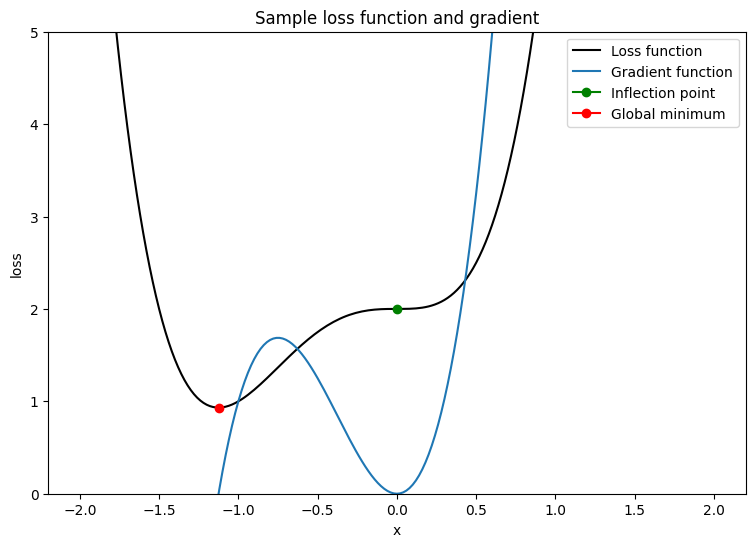

In [ ]:
x_vals = tf.linspace(-2, 2, 201)
x_vals = tf.cast(x_vals, tf.float32)

def loss(x):
    return 2*(x**4) + 3*(x**3) + 2

def grad(f, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        result = f(x)
    return tape.gradient(result, x)

plt.plot(x_vals, loss(x_vals), c='k', label = "Loss function")
plt.plot(x_vals, grad(loss, x_vals), c='tab:blue', label = "Gradient function")
plt.plot(0, loss(0),  marker="o", c='g', label = "Inflection point")
plt.plot(-9/8, loss(-9/8),  marker="o", c='r', label = "Global minimum")
plt.legend()
plt.ylim(0,5)
plt.xlabel("x")
plt.ylabel("loss")
plt.title("Sample loss function and gradient");

Develop a function to evaluate an optimizer's ability to converge on a loss function involving just one variable. Consider convergence to have occurred when the parameter's value at timestep \(t\) matches its value from timestep \(t-1\). Conclude the evaluation after a predetermined number of steps, and monitor for any instances of gradient explosion throughout the procedure. To rigorously test the optimizer, start with a suboptimal parameter initialization. For instance, setting \(x = 2\) is advisable as it not only presents a steep gradient but also approaches an inflection point.

In [ ]:
def convergence_test(optimizer, loss_fn, grad_fn=grad, init_val=2., max_iters=2000):
    # Function for optimizer convergence test
    print(optimizer.title)
    print("-------------------------------")
    # Initializing variables and structures
    x_star = tf.Variable(init_val)
    param_path = []
    converged = False

    for iter in range(1, max_iters + 1):
        x_grad = grad_fn(loss_fn, x_star)

    # Case for exploding gradient
    if tf.math.is_nan(x_grad):
        print(f"Gradient exploded at iteration {iter}\n")
        return []

    # Updating the variable and storing its old-version
    x_old = x_star.numpy()
    optimizer.apply_gradients([x_grad], [x_star])
    param_path.append(x_star.numpy())

    # Checking for convergence
    if x_star == x_old:
        print(f"Converged in {iter} iterations\n")
        converged = True
        break

    # Print early termination message
    if not converged:
        print(f"Exceeded maximum of {max_iters} iterations. Test terminated.\n")

    return param_path

Test the convergence of the gradient descent optimizer for the following learning rates: 1e-3, 1e-2, 1e-1

In [ ]:
param_map_gd = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
    param_map_gd[learning_rate] = (convergence_test(
        GradientDescent(learning_rate=learning_rate), loss_fn=loss))

Gradient descent optimizer: learning rate=0.001
-------------------------------
Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------
Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



Visualize the path of the parameters over a contour plot of the loss function.

In [ ]:
def viz_paths(param_map, x_vals, loss_fn, title, max_iters=2000):
    # Creating a controur plot of the loss function
    t_vals = tf.range(1., max_iters + 100.)
    t_grid, x_grid = tf.meshgrid(t_vals, x_vals)
    loss_grid = tf.math.log(loss_fn(x_grid))
    plt.pcolormesh(t_vals, x_vals, loss_grid, vmin=0, shading='nearest')
    colors = ['r', 'w', 'c']
    # Plotting the parameter paths over the contour plot
    for i, learning_rate in enumerate(param_map):
        param_path = param_map[learning_rate]
        if len(param_path) > 0:
            x_star = param_path[-1]
            plt.plot(t_vals[:len(param_path)], param_path, c=colors[i])
            plt.plot(len(param_path), x_star, marker='o', c=colors[i],
                    label = f"x*: learning rate={learning_rate}")
    plt.xlabel("Iterations")
    plt.ylabel("Parameter value")
    plt.legend()
    plt.title(f"{title} parameter paths")

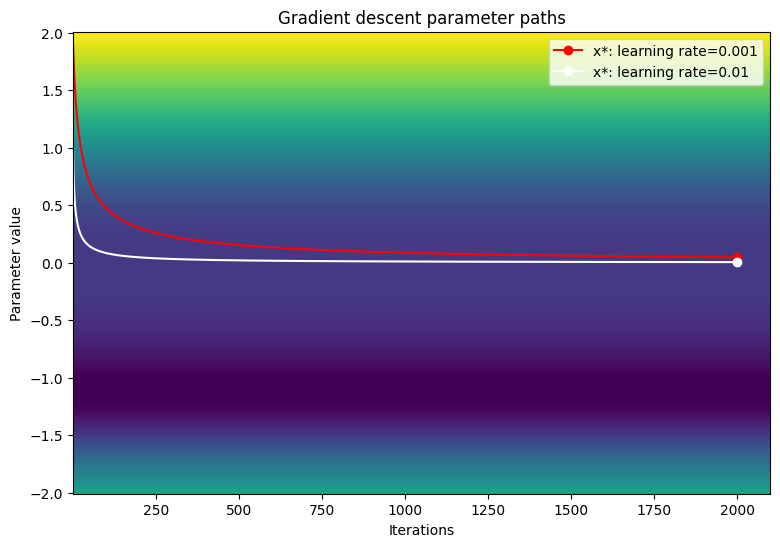

In [ ]:
viz_paths(param_map_gd, x_vals, loss, "Gradient descent")

Gradient descent seems to get stuck at the inflection point when using smaller learning rates. Increasing the learning rate can encourage faster movement around the plateau region due to a larger step size; however, this comes at the risk of having exploding gradients in early iterations when the loss function is extremely steep.

## Gradient descent with momentum


The method of gradient descent with momentum enhances the standard gradient descent approach by not only considering the current gradient of the loss function for updating a variable but also by taking into account the previous change in the variable's position. This addition helps in accelerating the optimization process, especially across areas of the loss landscape that are relatively flat, often referred to as plateau regions. The momentum parameter plays a crucial role here, as it dictates how much of the update from the previous timestep, denoted as $t-1$, influences the update at the current timestep, $t$.

To dive deeper into the mechanics, let's examine the momentum update rule, which is structured as follows:

1. The change in the variable $x$ at timestep $t$, denoted by $\Delta_x^{[t]}$, is computed by taking a weighted sum of two terms: the current gradient of the loss function with respect to $x$, scaled by the learning rate $lr$, and the previous update to $x$, scaled by the momentum parameter $p$. Mathematically, this is represented as:
   $$\Delta_x^{[t]} = lr \cdot L^\prime(x^{[t-1]}) + p \cdot \Delta_x^{[t-1]}$$
   
2. The variable $x$ is then updated by subtracting this change from its value at the previous timestep. This ensures that if the change $\Delta_x^{[t]}$ is positive, $x$ will decrease, moving towards a minimum of the loss function, and if $\Delta_x^{[t]}$ is negative, $x$ will increase. The update formula is given by:
   $$x^{[t]} = x^{[t-1]} - \Delta_x^{[t]}$$

Here, several key components are at play:

- $x$: This is the variable that we are attempting to optimize. We're essentially trying to find the value of $x$ that minimizes the loss function.
- $\Delta_x$: This represents the change applied to $x$ during the update process.
- $lr$ (learning rate): This parameter controls how large of a step is taken in the direction opposite to the gradient. A higher learning rate means larger steps, which can speed up convergence but also risk overshooting the minimum.
- $L^\prime(x)$: This is the gradient of the loss function with respect to $x$, providing the direction of steepest ascent. By moving in the opposite direction, we aim to minimize the loss.
- $p$ (momentum parameter): This parameter determines how much of the update from the previous step is included in the current update. It helps to build up speed, allowing the optimizer to move faster through plateau regions or to smooth out oscillations.

In essence, gradient descent with momentum combines the insight gained from the current gradient with the 'inertia' from the previous update, making the optimization process more effective by allowing for smoother and potentially quicker convergence to the minimum of the loss function.

In [ ]:
class Momentum(tf.Module):

    def __init__(self, learning_rate=1e-3, momentum=0.7):
        # Initialize parameters
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.change = 0.
        self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

    def apply_gradients(self, grads, vars):
        # Update variables
        for grad, var in zip(grads, vars):
            curr_change = self.learning_rate*grad + self.momentum*self.change
            var.assign_sub(curr_change)
            self.change = curr_change

Test the convergence of the momentum optimizer for the following learning rates: 1e-3, 1e-2, 1e-1

In [ ]:
param_map_mtm = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
    param_map_mtm[learning_rate] = (convergence_test(
        Momentum(learning_rate=learning_rate),
        loss_fn=loss, grad_fn=grad))

Gradient descent optimizer: learning rate=0.001
-------------------------------
Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------
Converged in 80 iterations

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



Visualize the path of the parameters over a contour plot of the loss function.

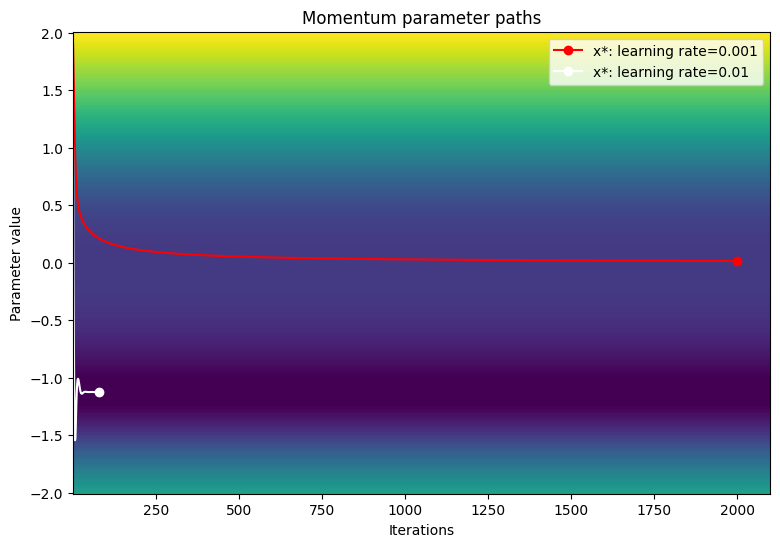

In [ ]:
viz_paths(param_map_mtm, x_vals, loss, "Momentum")

## Adaptive moment estimation (Adam)

The Adaptive Moment Estimation (Adam) algorithm is an efficient and highly generalizable optimization technique that leverages two key gradient descent methedologies: momentum, and root mean square propogation (RMSP). Momentum helps accelerate gradient descent by using the first moment (sum of gradients) along with a decay parameter. RMSP is similar; however, it leverages the second moment (sum of gradients squared).

The Adam algorithm combines both the first and second moment to provide a more generalizable update rule. The sign of a variable, $x$, can be determined by computing $\frac{x}{\sqrt{x^2}}$. The Adam optimizer uses this fact to calculate an update step which is effectively a smoothed sign. Instead of calculating $\frac{x}{\sqrt{x^2}}$, the optimizer calculates a smoothed version of $x$ (first moment) and $x^2$ (second moment) for each variable update.


**Adam algorithm**

$\beta_1 \gets 0.9 \; \triangleright \text{literature value}$:

$\beta_2 \gets 0.999 \; \triangleright \text{literature value}$

$lr \gets \text{1e-3} \; \triangleright \text{configurable learning rate}$

$\epsilon \gets \text{1e-7} \; \triangleright \text{prevents divide by 0 error}$

$V_{dv} \gets \vec {\underset{n\times1}{0}} \;\triangleright \text{stores momentum updates for each variable}$

$S_{dv} \gets \vec {\underset{n\times1}{0}} \; \triangleright \text{stores RMSP updates for each variable}$

$t \gets 1$

$\text{On iteration } t:$

$\;\;\;\; \text{For} (\frac{dL}{dv}, v) \text{ in gradient variable pairs}:$

$\;\;\;\;\;\;\;\; V_{dv\_i} = \beta_1V_{dv\_i} + (1 - \beta_1)\frac{dL}{dv} \; \triangleright \text{momentum update}$ ||| $V_{dv\_i}$ is updated with the new gradient, factoring in the momentum ($\beta_1$) and the immediate gradient change. This is known as the momentum update.

$\;\;\;\;\;\;\;\; S_{dv\_i} = \beta_2V_{dv\_i} + (1 - \beta_2)(\frac{dL}{dv})^2 \; \triangleright \text{RMSP update}$ ||| $S_{dv\_i}$ is similarly updated but squares the gradient before applying the RMSprop update ($\beta_2$). This captures the scale of the gradients and helps in adjusting the learning rate dynamically.


$\;\;\;\;\;\;\;\; v_{dv}^{bc} = \frac{V_{dv\_i}}{(1-\beta_1)^t} \; \triangleright \text{momentum bias correction}$

$\;\;\;\;\;\;\;\; s_{dv}^{bc} = \frac{S_{dv\_i}}{(1-\beta_2)^t} \; \triangleright \text{RMSP bias correction}$

Both $V_{dv}$ and $S_{dv}$ are then adjusted for bias. Since they are initialized as zeros and $\beta_1$ and $\beta_2$ are close to 1, the estimates of $V_{dv}$ and $S_{dv}$ would be biased towards zero initially. The bias correction terms ($v_{dv}^{bc}$ and $s_{dv}^{bc}$) correct this bias, making the estimates more accurate.

$\;\;\;\;\;\;\;\; v = v - lr\frac{v_{dv}^{bc}}{\sqrt{s_{dv}^{bc}} + \epsilon} \; \triangleright \text{parameter update}$ ||| The variable $v$ is updated by applying these bias-corrected estimates, effectively adjusting the parameter in the direction expected to minimize the loss, with the step size controlled by the learning rate ($lr$) and modulated by the square root of the bias-corrected RMSprop update plus $\epsilon$.

$\;\;\;\;\;\;\;\; t = t + 1$

**End of algorithm**

Given that $V_{dv}$ and $S_{dv}$ are initialized to 0 and that $\beta_1$ and $\beta_2$ are close to 1, the momentum and RMSP updates are naturally biased towards 0; therefore, the variables can benefit from bias correction. Bias correction also helps to control the osccilation of weights as they approach the global minimum.

The Adam algorithm is an optimization technique used in machine learning to update network weights iteratively based on training data. It combines elements of two other popular optimizers: momentum and RMSprop. Below is a more detailed explanation of the Adam algorithm's parameters and process, without altering the provided numbers and formulas.

- $\beta_1 \gets 0.9$ and $\beta_2 \gets 0.999$: These are the default values suggested in the literature for the hyperparameters that control the exponential decay rates for the moment estimates. They are crucial in determining the weighting of historical gradients versus the current gradient.
- $lr \gets \text{1e-3}$: This is the learning rate, a configurable parameter that affects the size of the steps taken during the optimization process. A smaller learning rate requires more training epochs through the dataset, whereas a larger learning rate might lead to overshooting the minimum.
- $\epsilon \gets \text{1e-7}$: A tiny number to prevent any division by zero in the implementation.
- $V_{dv}$ and $S_{dv}$: These vectors store the exponential moving averages of the gradient and its square, respectively. They are initialized as zero vectors, which means they start with no momentum.

Upon each iteration $t$ of the optimization process:
- For each pair of gradient and variable ($\frac{dL}{dv}$, $v$), the algorithm performs several updates:
    - $V_{dv\_i}$ is updated with the new gradient, factoring in the momentum ($\beta_1$) and the immediate gradient change. This is known as the momentum update.
    - $S_{dv\_i}$ is similarly updated but squares the gradient before applying the RMSprop update ($\beta_2$). This captures the scale of the gradients and helps in adjusting the learning rate dynamically.
    - Both $V_{dv}$ and $S_{dv}$ are then adjusted for bias. Since they are initialized as zeros and $\beta_1$ and $\beta_2$ are close to 1, the estimates of $V_{dv}$ and $S_{dv}$ would be biased towards zero initially. The bias correction terms ($v_{dv}^{bc}$ and $s_{dv}^{bc}$) correct this bias, making the estimates more accurate.
    - The variable $v$ is updated by applying these bias-corrected estimates, effectively adjusting the parameter in the direction expected to minimize the loss, with the step size controlled by the learning rate ($lr$) and modulated by the square root of the bias-corrected RMSprop update plus $\epsilon$.

This complex interplay of momentum and adaptive learning rate adjustments allows Adam to navigate the loss landscape more effectively than either momentum or RMSprop could on their own. The inclusion of bias correction ensures that the updates are more reliable early in training when the moving averages are still being established. This combination helps to stabilize the direction and size of the steps taken towards minimizing the loss function, ideally leading to faster and more reliable convergence to the global minimum.

In [ ]:
class Adam(tf.Module):

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        # Initialize the Adam parameters
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.learning_rate = learning_rate
        self.ep = ep
        self.t = 1.
        self.v_dvar, self.s_dvar = [], []
        self.title = f"Adam: learning rate={self.learning_rate}"
        self.built = False

    def apply_gradients(self, grads, vars):
        # Set up moment and RMSprop slots for each variable on the first call
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        # Perform Adam updates
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            # Moment calculation
            self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
            # RMSprop calculation
            self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var)
            # Bias correction
            v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
            s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
            # Update model variables
            var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
        # Increment the iteration counter
        self.t += 1.

Test the performance of the Adam optimizer with the same learning rates used with the gradient descent examples.

In [ ]:
param_map_adam = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
    param_map_adam[learning_rate] = (convergence_test(
        Adam(learning_rate=learning_rate), loss_fn=loss))

Adam: learning rate=0.001
-------------------------------
Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.01
-------------------------------
Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.1
-------------------------------
Converged in 1156 iterations



Visualize the path of the parameters over a contour plot of the loss function.

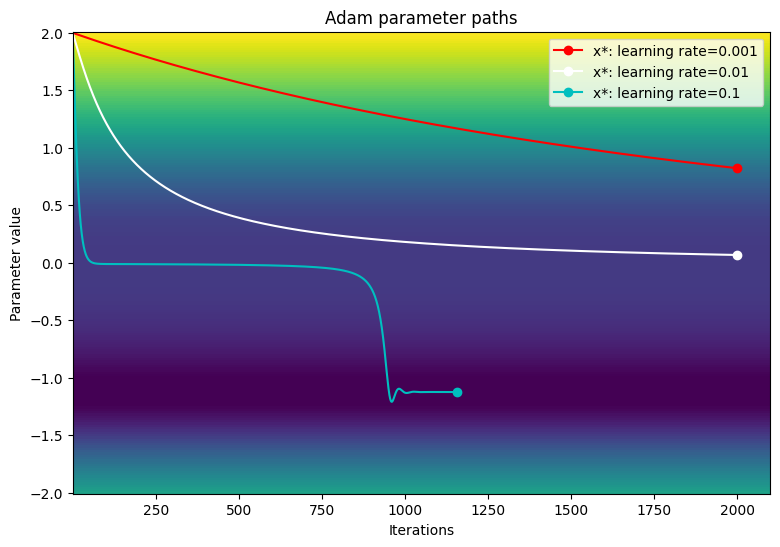

In [ ]:
viz_paths(param_map_adam, x_vals, loss, "Adam")

In this particular example, the Adam optimizer has slower convergence compared to traditional gradient descent when using small learning rates. However, the algorithm successfully moves past the plataeu region and converges to the global minimum when a larger learning rate. Exploding gradients are no longer an issue due to Adam's dynamic scaling of learning rates when encountering large gradients.